In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 

import polars.selectors as cs
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import missingno as mn

# dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"
dataPath = "../data/"

In [2]:
def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df

In [3]:
# 먼저 업로드된 데이터셋을 로드하여 데이터의 기본적인 구조와 결측치, 데이터 타입 등을 확인합니다.
import pandas as pd

# 데이터셋 로드
data_path = '../transcription/static_data.csv'
data = pd.read_csv(data_path)

# 데이터의 처음 몇 줄과 기본 정보를 출력합니다.
# data_info = data.info()
# data_head = data.head()

# data_info, data_head

[lightGBM 의 범주형 데이터처리](https://dataplay.tistory.com/2)

In [4]:
# 불필요한 컬럼 제거
data.drop(columns=['Unnamed: 0'], inplace=True)

# 결측치 비율 계산
missing_values = data.isnull().mean().sort_values(ascending=False)

# 상위 10개 컬럼의 결측치 비율 출력
missing_values.head(30)

dateofbirth_342D           0.976092
forweek_1077L              0.976082
for3years_128L             0.976082
formonth_118L              0.976082
formonth_206L              0.976082
formonth_535L              0.976082
forquarter_1017L           0.976082
forquarter_634L            0.976082
fortoday_1092L             0.976082
for3years_584L             0.976082
forquarter_462L            0.976082
forweek_528L               0.976082
forweek_601L               0.976082
foryear_618L               0.976082
foryear_818L               0.976082
foryear_850L               0.976082
for3years_504L             0.976082
riskassesment_302T         0.964918
riskassesment_940T         0.964917
assignmentdate_4955616D    0.953079
pmtcount_4955617L          0.952940
pmtaverage_4955615A        0.952940
pmtaverage_4527227A        0.924687
pmtcount_4527229L          0.924687
assignmentdate_4527235D    0.924687
assignmentdate_238D        0.910264
pmtaverage_3A              0.905946
pmtcount_693L              0

<module 'matplotlib.pyplot' from 'c:\\Users\\hmk40\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

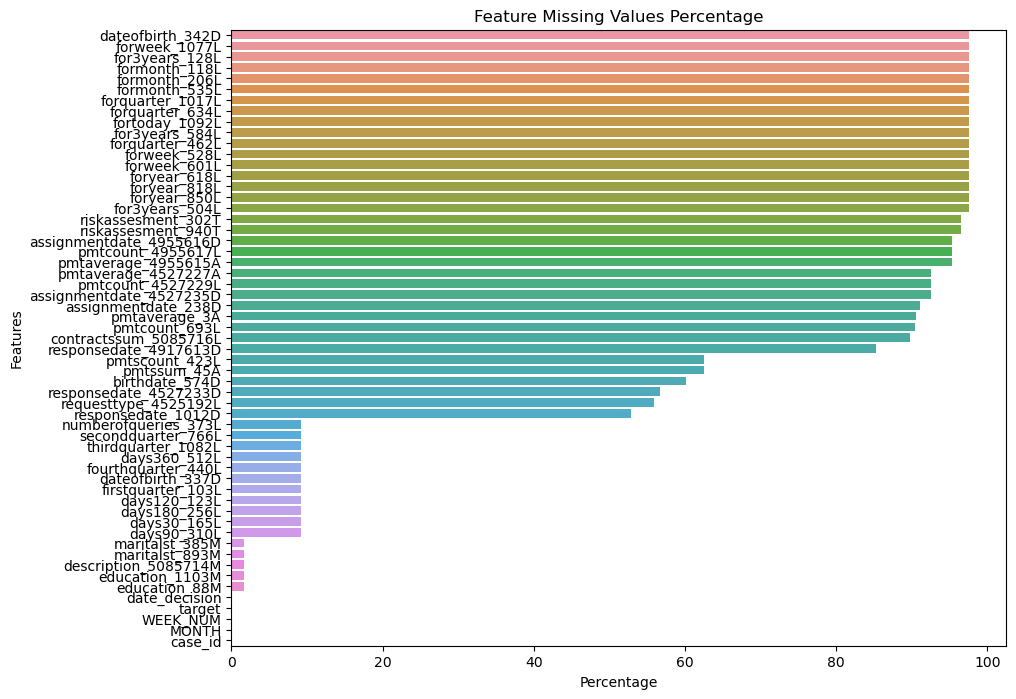

In [5]:
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=missing_values.values * 100, y=missing_values.index)
plt.title('Feature Missing Values Percentage')
plt.xlabel('Percentage')
plt.ylabel('Features')

plt

In [6]:
# 결측치 비율이 50% 이상인 컬럼 식별
high_missing_cols = missing_values[missing_values > 0.95].index.tolist()

# # 단일 값만을 갖는 경우, 해당 값의 존재 여부를 나타내는 새로운 컬럼 생성
# for col in high_missing_cols:
#     # 해당 컬럼이 단일 값을 갖는지 확인
#     if len(data[col].dropna().unique()) == 1:
#         # 단일 값의 존재 여부를 나타내는 새로운 컬럼 추가 (1: 값 존재, 0: 결측치)
#         data[col + '_exists'] = data[col].notnull().astype(int)

# 단일 값을 갖는 컬럼을 제외하고 나머지 결측치 비율이 높은 컬럼 제거
cols_to_remove = [col for col in high_missing_cols if len(data[col].dropna().unique()) > 1]
data.drop(columns=cols_to_remove, inplace=True)

# 변경 후 데이터 프레임의 컬럼 개수 확인
remaining_cols_count = data.shape[1]
remaining_cols_count, cols_to_remove

(38,
 ['dateofbirth_342D',
  'forweek_1077L',
  'for3years_128L',
  'formonth_206L',
  'formonth_535L',
  'forquarter_1017L',
  'forquarter_634L',
  'fortoday_1092L',
  'for3years_584L',
  'forweek_528L',
  'foryear_618L',
  'foryear_818L',
  'foryear_850L',
  'for3years_504L',
  'riskassesment_302T',
  'riskassesment_940T',
  'assignmentdate_4955616D',
  'pmtcount_4955617L',
  'pmtaverage_4955615A'])

In [7]:
# 추가로 쓸모없으릴 판단한 것들
data.drop(columns=['forweek_601L', 'forquarter_462L', 'formonth_118L', 'assignmentdate_4527235D', 'assignmentdate_238D', 'contractssum_5085716L', 'birthdate_574D'], inplace=True)

In [8]:
# 결측치 비율 계산
missing_values = data.isnull().mean().sort_values(ascending=False)

# 상위 10개 컬럼의 결측치 비율 출력
missing_values.head(10)

pmtcount_4527229L        0.924687
pmtaverage_4527227A      0.924687
pmtaverage_3A            0.905946
pmtcount_693L            0.904100
responsedate_4917613D    0.852677
pmtssum_45A              0.624908
pmtscount_423L           0.624908
responsedate_4527233D    0.567469
requesttype_4525192L     0.558995
responsedate_1012D       0.528382
dtype: float64

`pmt` - 세금공제관련

In [9]:
tax_deduction = data.columns[data.columns.str.contains('pmt')]
tax_deduction

Index(['pmtaverage_3A', 'pmtaverage_4527227A', 'pmtcount_4527229L',
       'pmtcount_693L', 'pmtscount_423L', 'pmtssum_45A'],
      dtype='object')

In [10]:
data[tax_deduction].describe()

,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A
count,143589.000000,114978.000000,114978.000000,146406.000000,572638.000000,572638.000000
mean,9303.171700,10033.556094,6.598027,5.714991,5.839291,13199.935970
std,5562.386995,5455.843604,2.188992,1.758117,4.148264,18117.218312
min,0.000000,4.200000,1.000000,0.000000,0.000000,0.000000
25%,6590.600000,7192.000000,6.000000,6.000000,3.000000,3156.400100
50%,7305.900000,7553.000000,6.000000,6.000000,6.000000,8391.900000
75%,13023.900000,13464.400000,6.000000,6.000000,7.000000,16992.000000
max,145257.400000,205848.610000,15.000000,66.000000,121.000000,476843.400000


In [11]:
#count
columns_to_sum = data.columns[data.columns.str.contains('pmt') & data.columns.str.contains('L')]
row_sums = data[columns_to_sum].sum(axis=1)
data['pmtcount_A'] = row_sums
#amount
columns_to_sum = data.columns[data.columns.str.contains('pmt') & data.columns.str.contains('A')]
row_sums = data[columns_to_sum].sum(axis=1)
data['pmtamount_A'] = row_sums
data.drop(columns=tax_deduction, inplace=True)

In [12]:
data.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,...,maritalst_893M,numberofqueries_373L,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,pmtcount_A,pmtamount_A
0,0,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,1,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2,2019-01-04,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,3,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


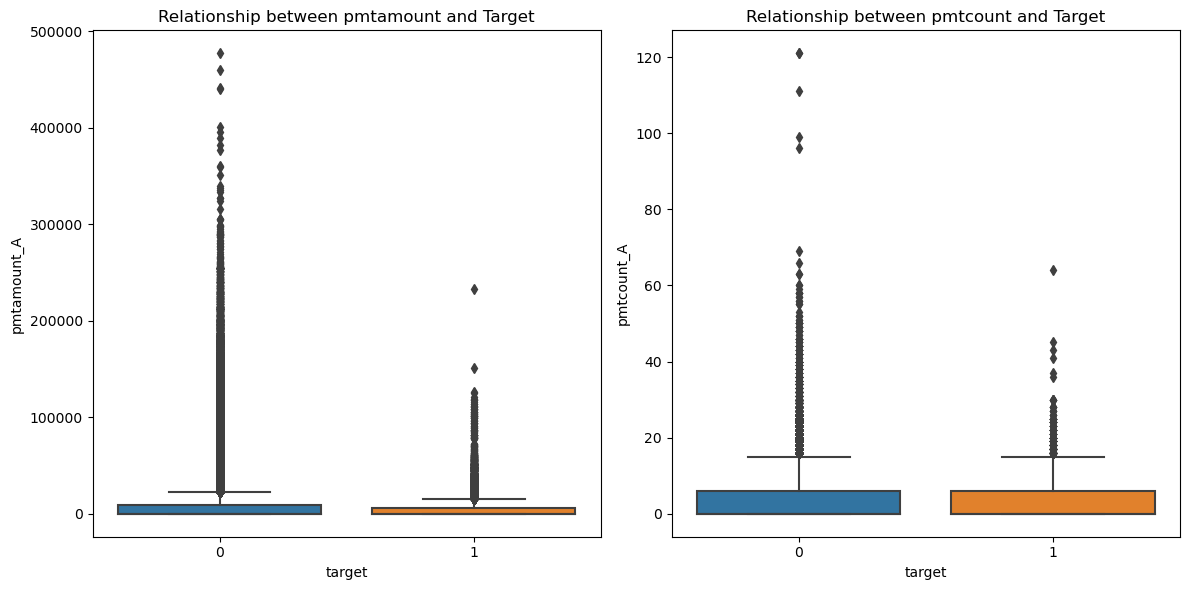

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='pmtamount_A', data=data)
plt.title('Relationship between pmtamount and Target')

plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='pmtcount_A', data=data)
plt.title('Relationship between pmtcount and Target')

plt.tight_layout()
plt.show()

In [14]:
len(data.loc[data['pmtamount_A'] > 130000])

2005

In [15]:
## 버린다
data.drop(columns=['pmtamount_A', 'pmtcount_A'], inplace=True)

In [16]:
data.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,...,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L
0,0,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# 결측치 비율 계산
missing_values = data.isnull().mean().sort_values(ascending=False)

# 상위 10개 컬럼의 결측치 비율 출력
missing_values

responsedate_4917613D    0.852677
responsedate_4527233D    0.567469
requesttype_4525192L     0.558995
responsedate_1012D       0.528382
thirdquarter_1082L       0.092338
secondquarter_766L       0.092338
dateofbirth_337D         0.092338
days120_123L             0.092338
days180_256L             0.092338
days30_165L              0.092338
days360_512L             0.092338
days90_310L              0.092338
numberofqueries_373L     0.092338
firstquarter_103L        0.092338
fourthquarter_440L       0.092338
maritalst_893M           0.017151
education_1103M          0.017151
maritalst_385M           0.017151
education_88M            0.017151
description_5085714M     0.017151
date_decision            0.000000
target                   0.000000
WEEK_NUM                 0.000000
MONTH                    0.000000
case_id                  0.000000
dtype: float64

<Axes: >

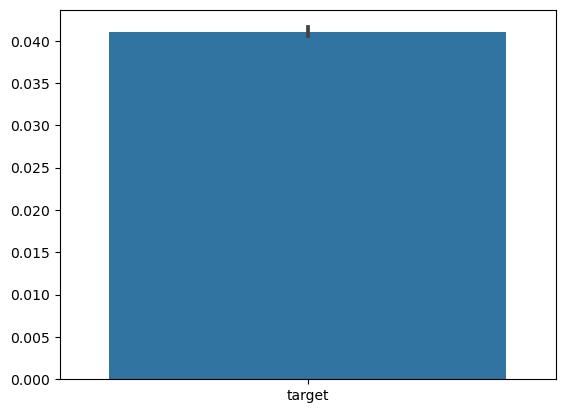

In [18]:
sns.barplot(data=data.loc[data['requesttype_4525192L']=='DEDUCTION_6', ['target']])